In [4]:
!pip install tqdm

In [8]:
!pip install ipympl

     |████████████████████████████████| 507 kB 607 kB/s eta 0:00:01


In [5]:
import serial
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [21]:
byte2np = lambda x: np.array(x.decode().replace("\r\n","").split(",")).astype('f')

In [83]:
%matplotlib widget

target = "ANOM3"

xx=[]
yy=[]

ser = serial.Serial("/dev/ttyACM0",115200, timeout=1)

for i in tqdm(range(1000)):
#for i in range(1000):
    try:
        data = byte2np(ser.readline()) #byte2np = lambda x: np.array(x.decode().replace("\r\n","").split(",")).astype('i')
        #data = ser.readline()
        #print(data)
    except:
        pass
    #print(data)
    time.sleep(0.001)
    
    xx.append(data[0:3])
    yy.append(data[3:])
    
#plt.plot(xx)
#plt.plot(yy)
#plt.grid(True)
ser.close()

100%|███████████████████████████████████████| 1000/1000 [00:15<00:00, 65.84it/s]


In [84]:
X = np.hstack([xx,yy])

df1 = pd.DataFrame(X, columns=('ax','ay','az','gx','gy','gz'))
df1['target'] = target
df1.head()

,ax,ay,az,gx,gy,gz,target
0,6.28,-0.86,7.81,0.16,-0.08,-0.20,ANOM3
1,6.21,-0.49,7.86,0.13,-0.06,-0.24,ANOM3
2,5.88,-0.57,8.14,0.11,-0.06,-0.22,ANOM3
3,5.75,-0.97,8.40,0.16,-0.07,-0.17,ANOM3
4,5.85,-0.79,8.12,0.18,-0.07,-0.16,ANOM3


In [85]:
df1.to_csv(target+".csv",index=False)

In [86]:
path = "/home/omar/Documents/proyectos_tinyml/DATASET.csv"

In [87]:
dataset = pd.read_csv(path)
dataset.head()

,ax,ay,az,gx,gy,gz,target
0,-9.46,-6.50,5.00,0.61,0.43,-0.80,0
1,5.69,-0.97,8.35,0.26,-0.06,-0.02,0
2,5.84,-0.08,7.46,0.24,-0.05,-0.02,0
3,6.16,-0.60,7.30,0.31,-0.08,0.00,0
4,6.41,-1.58,8.14,0.30,-0.12,0.03,0


In [119]:
X = dataset.iloc[1:,0:-1].astype("float").to_numpy()
y = dataset.iloc[:,-1].astype("i").to_numpy()

In [120]:
X

array([[ 5.69, -0.97,  8.35,  0.26, -0.06, -0.02],
       [ 5.84, -0.08,  7.46,  0.24, -0.05, -0.02],
       [ 6.16, -0.6 ,  7.3 ,  0.31, -0.08,  0.  ],
       ...,
       [ 6.32, -1.59,  7.71,  0.27, -0.11,  0.06],
       [ 6.01, -1.58,  7.89,  0.23, -0.09,  0.02],
       [ 5.62, -1.6 ,  8.08,  0.18, -0.06,  0.  ]])

In [121]:
y

array([0, 0, 0, ..., 2, 2, 2], dtype=int32)

In [99]:
!pip install embedded_window

  Created wheel for embedded-window: filename=embedded_window-0.0.2-py3-none-any.whl size=3420 sha256=5d91b3c65b524f59d00e13bf14293a97aa09cd7c7671e7121b09c1cae502d2af
  Stored in directory: /home/omar/.cache/pip/wheels/60/1d/5e/ab367433820e40c47b560bdcdb7ed1c9a68ef1cc1727ab93bc
Successfully built embedded-window


In [122]:
# this goes at the top of the Python script
from embedded_window import Window

# the rest goes right after the previous block of code
# if using a board different than Rp2040 Connect, the sampling rate may be different!
SAMPLING_RATE = 104
# this is in milliseconds
WINDOW_DURATION = 500

window = Window(length=SAMPLING_RATE * WINDOW_DURATION // 1000, shift=WINDOW_DURATION // 20)

# X_windows holds the input arranged in windows
# features holds the extracted features for each window (min/max/mean/std...)
# y_windows holds the most frequent label inside each window 
X_windows, features, y_windows = window.fit_transform(X, y)

print('X_windows.shape', X_windows.shape)
print('features.shape', features.shape)
print('y_windows.shape', y_windows.shape)

X_windows.shape (478, 52, 6)
features.shape (478, 48)
y_windows.shape (478,)


In [134]:
!pip install sklearn

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix

# use half data for training, half for testing
X_train, X_test, y_train, y_test = train_test_split(features, y_windows, test_size=0.5, random_state=0)
clf = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=0).fit(X_train, y_train)

/home/omar/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


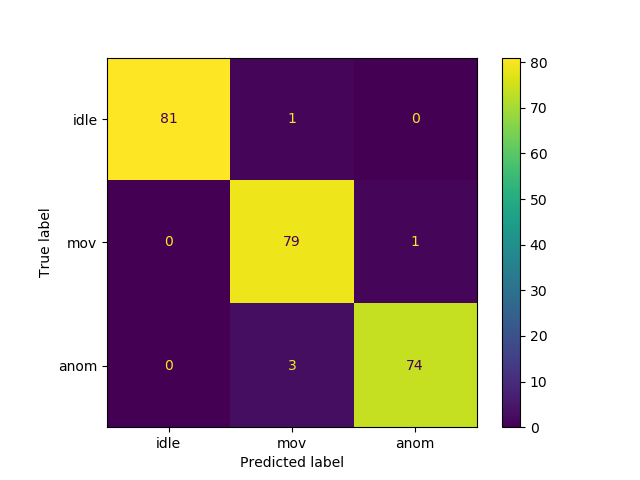

In [133]:
plot_confusion_matrix(clf, X_test, y_test, normalize=None, display_labels=['idle', 'mov', 'anom'])
plt.show()

In [137]:
!pip install micromlgen

  Created wheel for micromlgen: filename=micromlgen-1.1.27-py3-none-any.whl size=32068 sha256=bc571c0d0d512b62cb22264f64b3940f1a31c865e701c3caff43b5395bdb4bcc
  Stored in directory: /home/omar/.cache/pip/wheels/7a/5d/4d/d72d1e8456c5750d61da1aeba4fa6cd389629d9e83ac74a252
Successfully built micromlgen


In [139]:
with open("Window.h", "w") as file:
    file.write(window.port())

In [140]:
from micromlgen import port

with open("Classifier.h", "w") as file:
    file.write(port(clf, classname="Classifier", classmap={0: "idle", 1: "mov", 2: "anom"}))